# <font color = green> PROCESSAMENTO DE IMAGENS BIOMÉDICAS </font>

In [152]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np

import pydicom
from pydicom.data import get_testdata_files
from pydicom.data.data_manager import get_files

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix

#models import
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 


## <font color = green> TESTANDO A LIB PYDICOM </font>

In [153]:
# Para abrir apenas uma imagem DICOM, podemos utilizar o get_files 
# path = "CINTILOGRAFIAS/BMT/P1A"
# dicom = "D405923.dcm"
# filename = get_files(path, dicom)[0]

In [154]:
# Le e retorna um dataset
# ds = pydicom.dcmread(filename)

In [155]:
# ds.PatientName

In [156]:
# ds

In [157]:
# Para verificarmos  a matriz da imagem utilizamos o pixel_array
# ds.pixel_array

## <font color = green> ABERTURA DAS IMAGENS </font>

### Salvando a matriz das imagens em duas listas que representam as classes 

In [158]:
bmt = []
graves = []

paths = glob.glob("CINTILOGRAFIAS/BMT/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    bmt.append(dataset.pixel_array)
    
paths = glob.glob("CINTILOGRAFIAS/GRAVES/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    graves.append(dataset.pixel_array)

### Visualizacao

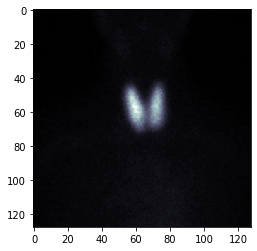

In [159]:
plt.imshow(graves[0], cmap=plt.cm.bone) 

### Salvando a imagem em JPG

In [160]:
# plt.imsave('bmt06.png', bmt[6])

## <font color = green> PRÉ-PROCESSAMENTO </font>

### Segmentacao da regiao de interesse
#### Como todas as imagens possuem tamanho padrão de 128x128 o corte será realizado no centro da imagem. O slice começará no pixel 32 e terminará no 96, para ambas as dimensões. 

In [161]:
# Graves
for index, image in enumerate(graves):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    graves[index] = cropped_image

# BMT
for index, image in enumerate(bmt):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    bmt[index] = cropped_image

### Reducao de ruído

In [162]:
# Graves
for index, image in enumerate(graves):
    graves[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/grave' + str(index) + '.jpg', graves[index], cmap='gray')

# BMT
for index, image in enumerate(bmt):
    bmt[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/bmt' + str(index) + '.jpg', bmt[index], cmap='gray')

## <font color = green> HISTOGRAMA </font>

#### Intensidade do maior pixel da imagem

In [163]:
# for index, image in enumerate(graves):
#     print(graves[index].max())

### Um histograma por classe
#### cv2.calcHist (image, channel, mask, histSize, histRange)

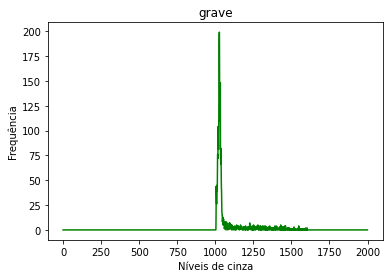

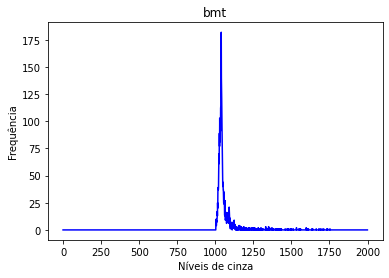

In [164]:
hist_graves = cv2.calcHist (graves, [0], None, [2000], [-1000, 1000])
hist_bmt = cv2.calcHist (bmt, [0], None, [2000], [-1000, 1000])

plt.figure()
plt.title('grave')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_graves, color = 'green')  
plt.savefig('histogramas/grave_class.png')

plt.figure()
plt.title('bmt')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_bmt, color = 'blue')  
plt.savefig('histogramas/bmt_class.png')

### Comparando os dois histogramas

In [165]:
compare = cv2.compareHist(hist_graves, hist_bmt, cv2.HISTCMP_CORREL)

In [166]:
compare

0.7167720895882537

## <font color = green> SEGMENTAÇÃO E CONTORNO </font>

In [167]:
# Graves
print("\nGRAVE")
for index, image in enumerate(graves):
    # Threshold
    thresh = cv2.threshold(graves[index], 100, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/graves' + str(index) + '.jpg', thresh, cmap='gray')
    
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = graves[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/graves' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print (0.0)

# BMT
print("\nBMT")
for index, image in enumerate(bmt):
    # Threshold
    thresh = cv2.threshold(bmt[index], 130, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/bmt' + str(index) + '.jpg', thresh, cmap='gray')
        
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = bmt[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/bmt' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print("Área:", 0.0, "\n")


GRAVE


error: OpenCV(4.5.1) /tmp/pip-req-build-n_alixql/opencv/modules/imgproc/src/drawing.cpp:2501: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


## <font color = green> Extração de Características </font>

In [ ]:
def calcula_contorno(images):
    areas = []
    objetos = []
    for image in images:
        # Threshold
        thresh = cv2.threshold(image, 130, 200, cv2.THRESH_BINARY)[1]
        thresh = thresh.astype(np.uint8)
            
        # Contours
        cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
       
        # Area
        if len(cnt) > 0:
            cnt = cnt[0]
            area = cv2.contourArea(cnt)

        else:
            area = 0.0

        areas.append(area)
        objetos.append(len(cnt))

    return areas, objetos 

areas_bmt, objetos_bmt = calcula_contorno(bmt)
areas_graves, objetos_graves = calcula_contorno(graves)

print('Areas BMT: ', areas_bmt)
print('Areas graves: ', areas_graves)

print('Objetos BMT: ', objetos_bmt)
print('Objetos graves: ', objetos_graves) 

Areas BMT:  [64.0, 33.0, 0.0, 48.5, 0.0, 437.5]
Areas graves:  [484.0, 595.0, 148.0, 325.5, 617.5, 339.5]
Objetos BMT:  [13, 13, 0, 15, 0, 43]
Objetos graves:  [42, 50, 22, 35, 47, 39]


In [ ]:
def calcula_histogramas(images):
    histogramas = []
    for img in images:
        hist = cv2.calcHist(img, [0], None, [50], [0, 50])
        histogramas.append(hist)
    
    return histogramas 

hists_bmt = calcula_histogramas(bmt)
hists_graves = calcula_histogramas(graves) 

print('histogramas bmt: ', np.array(hists_bmt).shape)
print('histogramas graves: ', np.array(hists_graves).shape)

histogramas bmt:  (6, 50, 1)
histogramas graves:  (6, 50, 1)


### Vetor de caracteristicas

In [ ]:
def concat_features(hists, areas, objs):
    features = []
    for hist, area, obj in zip(hists, areas, objs):
        sample = np.append(np.reshape(hist, (50,)) , area)
        sample = np.append(sample, obj)

        features.append(sample)

    return features 

features_bmt = concat_features(hists_bmt, areas_bmt, objetos_bmt)
features_grave = concat_features(hists_graves, areas_graves, objetos_graves)

print(np.array(features_bmt).shape)
print(np.array(features_grave).shape)


(6, 52)
(6, 52)


### Prepara base consolidada

In [ ]:
bmt_labels = ['BMT' for x in range(len(bmt))]
grave_labels = ['Grave' for x in range(len(graves))]

X = np.array(features_bmt + features_grave)
y = np.append(bmt_labels, grave_labels)

print('X: ', X)
print('y: ', y)

X:  [[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.    0.    1.    0.    0.    0.
    0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
    0.    1.    2.    0.    2.    3.    5.    2.    3.    1.    1.    2.
    0.    0.   64.   13. ]
 [  0.    0.    0.    2.    4.    1.    1.    2.    0.    2.    0.    1.
    0.    1.    1.    1.    0.    1.    1.    0.    2.    0.    1.    2.
    0.    0.    2.    0.    0.    1.    1.    0.    0.    1.    2.    0.
    3.    3.    2.    2.    1.    1.    1.    2.    0.    1.    0.    1.
    1.    0.   33.   13. ]
 [  0.    0.    3.    1.    0.    1.    1.    1.    1.    0.    1.    1.
    0.    0.    0.    2.    0.    0.    1.    1.    0.    0.    1.    1.
    0.    0.    0.    0.    1.    1.    0.    0.    0.    0.    1.    1.
    0.    2.    1.    2.    2.    3.    3.    4.    2.    1.    2.    3.
    1.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.   

In [ ]:
np.random.seed(13)


In [ ]:
from sklearn.utils import shuffle

print('y: ', y)
X, y = shuffle(X, y, random_state = 13)
print('y: ', y)

y:  ['BMT' 'Grave' 'Grave' 'Grave' 'Grave' 'Grave' 'Grave' 'BMT' 'BMT' 'BMT'
 'BMT' 'BMT']
y:  ['Grave' 'BMT' 'Grave' 'BMT' 'BMT' 'Grave' 'Grave' 'BMT' 'Grave' 'BMT'
 'BMT' 'Grave']


## <font color=green> Criação do Modelo </font>

 *  Testar arvore de decisao, KNN, Naive Bayes

Por que?
 
Algoritmos de aprendizado de máquina que não necessitam muitos dados para serem treinados 

In [ ]:
classificadores = { 
    'Decision Tree': DecisionTreeClassifier(random_state=13),
    'Naive Bayes': GaussianNB(),
    'KNN' : KNeighborsClassifier(n_neighbors=2), 
    'MLP' : MLPClassifier(random_state=13)
}

preds = {
    'Decision Tree': [],
    'Naive Bayes' : [], 
    'KNN' : [],
    'MLP' : [], 
} 


loo = LeaveOneOut()
n_folds = loo.get_n_splits(X)

count = 1
y_true = []  

for train_index, test_index in loo.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test , y_test  = X[test_index] , y[test_index]
    print('Fold {}/{}'.format(count, n_folds))
    for name, clf in classificadores.items():
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        preds[name].append(y_pred)

    y_true.append(y_test)
    count += 1
    

Fold 1/12
Fold 2/12
Fold 3/12
Fold 4/12
Fold 5/12
Fold 6/12
Fold 7/12
Fold 8/12
Fold 9/12
Fold 10/12
Fold 11/12
Fold 12/12


## <font color = 'green' > Avaliacao dos modelos </font>

In [171]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

for name, y_pred in preds.items():

    y_true = converte_label(y_true)
    y_pred = converte_label(y_pred)
    print('Avaliando ', name)
    #print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print('acc:', accuracy_score(y_true, y_pred))
    print('prec: ',precision_score(y_true, y_pred))
    print('recall: ',recall_score(y_true, y_pred))
    print('f1score: ', f1_score(y_true, y_pred))
    print('=============================================')

    

Avaliando  Decision Tree
[[3 3]
 [3 3]]
acc: 0.5
prec:  0.5
recall:  0.5
f1score:  0.5
Avaliando  Naive Bayes
[[2 4]
 [3 3]]
acc: 0.4166666666666667
prec:  0.42857142857142855
recall:  0.5
f1score:  0.4615384615384615
Avaliando  KNN
[[5 1]
 [4 2]]
acc: 0.5833333333333334
prec:  0.6666666666666666
recall:  0.3333333333333333
f1score:  0.4444444444444444
Avaliando  MLP
[[5 1]
 [1 5]]
acc: 0.8333333333333334
prec:  0.8333333333333334
recall:  0.8333333333333334
f1score:  0.8333333333333334


## <font color = 'green'>Visualizacao Features </font>

In [151]:
def converte_label(string_labels):
    unique_labels = np.unique(string_labels)
    number_labels = []
    for i in range(len(string_labels)):
        for j in range(len(unique_labels)):
            if(string_labels[i] == unique_labels[j]):
                 number_labels.append(j)

    return number_labels

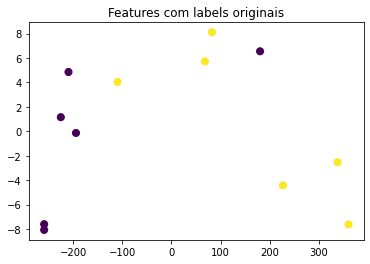

In [135]:
pca = PCA(2)
simple_features = pca.fit_transform(X)
y_number = converte_label(y)

plt.scatter(simple_features[:, 0], simple_features[:, 1], c=y_number, s=50, cmap='viridis')
plt.title('Features com labels originais')
plt.show()

In [ ]:
cv2.calcHist(img, 1, 0, 255, 0, 50)